In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [261]:
import cirq
import cirq_superstaq as css
import ldpc
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pymatching
import sinter
import stim
import stimcirq
from ldpc.sinter_decoders import SinterBeliefFindDecoder, SinterBpOsdDecoder

import qldpc

In [4]:
# [X,Z] gates don't contribute to [X, Z] basis SPAM

In [253]:
def gen_syndrome_surface_circuit(surface_code, repetitions=1):
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()

    ancillas_x = [cirq.NamedQubit(f"ax{anc_idx}") for anc_idx in range(len(surface_code.matrix_x))]
    ancillas_z = [cirq.NamedQubit(f"az{anc_idx}") for anc_idx in range(len(surface_code.matrix_z))]

    # circuit for a single round of syndrome extraction

    stab_circuit = cirq.Circuit()

    for ancillas, matrix, gate in zip([ancillas_x, ancillas_z], [surface_code.matrix_x, surface_code.matrix_z], [cirq.CX, cirq.CZ]):
        stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas))
        for anc, row in zip(ancillas_x, matrix):
            for bit_idx, bit in enumerate(row):
                if bit:
                    stab_circuit += gate(anc, cirq.LineQubit(bit_idx))
        stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas))
        stab_circuit += cirq.Moment(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on_each(*ancillas))

    # First round of stabilizer checks
    circuit = stab_circuit.copy()
    
    ancillas = sorted([q for q in circuit.all_qubits() if isinstance(q, cirq.NamedQubit)])
    data = sorted([q for q in circuit.all_qubits() if q not in ancillas])

    indices = [i - len(ancillas) for i, anc in enumerate(ancillas) if anc.name[:2] == "ax"]
    circuit += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x]) for x in indices])
    # Make this work for general code
    
    
    
    # Repeat Block
    circuit_op = stab_circuit.copy()
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[anc, anc-len(ancillas)]) for anc in range(-len(ancillas), 0)])
    # Make this work for general code
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    # measure out data qubits
    for idx, d in enumerate(data):
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)

    # compare data qubit measurements with parity measurements
    moment = []
    for i, anc_idx in enumerate(range(len(surface_code.matrix_x))): # Make this work for general code
        data_indices = [idx - len(data) for idx, element in enumerate(surface_code.matrix_x[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits())] + data_indices, coordinate_metadata = (i, 1)))
    circuit += cirq.Moment(moment)

    # check logical observables
    logical_x = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
    logical_z = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)
    
    for i, lx in enumerate(logical_x):
        observable_keys = [idx - len(data) for idx, element in enumerate(lx) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))

    # prepa
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q) for q in data])
    moment += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='Z', invert_measure=False, key="").on(q) for q in ancillas])
    circuit.insert(0, moment)
    
    
    return circuit

In [254]:
class NoiseModel(cirq.NoiseModel):

    def __init__(self, error_prob):
        self.error_prob = error_prob

    def noisy_operation(self, operation: 'cirq.Operation') -> 'cirq.OP_TREE':
        if not operation.qubits:
            return operation

        if isinstance(operation, cirq.CircuitOperation):
            new_subcirc = operation.circuit.unfreeze().with_noise(self)
            return cirq.CircuitOperation(
                new_subcirc.freeze(),
                repeat_until=operation.repeat_until,
                use_repetition_ids=operation.use_repetition_ids,
            )

        if isinstance(operation.gate, cirq.MeasurementGate):
            # spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
            spam = cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)
            return [spam, operation, spam]
        return [operation, cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)]
            

In [257]:
# from sympy.abc import x, y, z
# dims = {x: 12, y: 6}
# poly_a = x**3 + y + y**2
# poly_b = y**3 + x + x**2

# code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-3.5, -1.5, 10)
code_name = "Rotated Surface Code"
file_name = ("_".join(code_name.split())).lower()
# base_code = qldpc.codes.HammingCode(2)
# group = qldpc.abstract.CyclicGroup(4)
# code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [3]:
            code = qldpc.codes.SurfaceCode(d, rotated=True)
            circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, repetitions=d).with_noise(NoiseModel(noise)))
            yield sinter.Task(
                circuit=circuit,
                detector_error_model=circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )


def run_simulation(overwrite=True):

    filename = f'bposd_{file_name}.csv'
    
    if overwrite:
        pathlib.Path(filename).unlink()

    samples = sinter.collect(
        num_workers=10,
        max_shots=100_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        decoders=['bposd'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0")
        },

        print_progress=True,
        save_resume_filepath=filename,
    )
    return(samples)

In [258]:
samples = run_simulation()
samples

Starting 10 workers...
Running...
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.00031622776601683794,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.0005274997063702619,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.0008799225435691075,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.0014677992676220691,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.002448436746822227,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.004084238652674522,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.006812920690579608,repetitions=3}
    bposd processes=1  

[sinter.TaskStats(strong_id='a0ccc5abd75d67d1a212f4104d15f894cea049ead0963658b1f94517782ed271', decoder='bposd', json_metadata={'noise': 0.00031622776601683794, 'd': 3, 'repetitions': 3}, shots=100000, errors=1, seconds=3.8046025940020627),
 sinter.TaskStats(strong_id='defa7ce59c938ee87a5c51d8a3c2c0e995451affd97214e831ac6d2acedbc779', decoder='bposd', json_metadata={'noise': 0.0005274997063702619, 'd': 3, 'repetitions': 3}, shots=100000, errors=8, seconds=3.501822168014769),
 sinter.TaskStats(strong_id='78c411ede96771085df414b35910ea1db6d6c26646b31d0cbe1aadd5ee5e7edc', decoder='bposd', json_metadata={'noise': 0.0008799225435691075, 'd': 3, 'repetitions': 3}, shots=100000, errors=13, seconds=3.8220762770033616),
 sinter.TaskStats(strong_id='f13096fa4a0788d62e88c289235629a86ec582c8bb21f5d2f5f0c399f81e8800', decoder='bposd', json_metadata={'noise': 0.0014677992676220691, 'd': 3, 'repetitions': 3}, shots=100000, errors=54, seconds=3.7149019650059927),
 sinter.TaskStats(strong_id='5ecd6bc6d

In [259]:
def print_results(samples):
 # Print samples as CSV data.
    print(sinter.CSV_HEADER)
    for sample in samples:
        print(sample.to_csv_line())

def plot_results(samples):
    # Render a matplotlib plot of the data.
    fig, axis = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    sinter.plot_error_rate(
        ax=axis,
        stats=samples,
        group_func=lambda stat: f"{code_name} d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'bposd',
        x_func=lambda stat: stat.json_metadata['noise'],
    )

    axis.set_ylabel('Logical Error Rate')
    axis.set_title(f'{code_name} threshold with BPOSD')

    axis.plot(noise_range, noise_range, "--", color="k")
    axis.loglog()
    axis.grid()
    axis.set_xlabel('Physical Error Rate')
    axis.legend()

    # Save to file and also open in a window.
    fig.savefig(f'{file_name}_plot.png')
    plt.show()

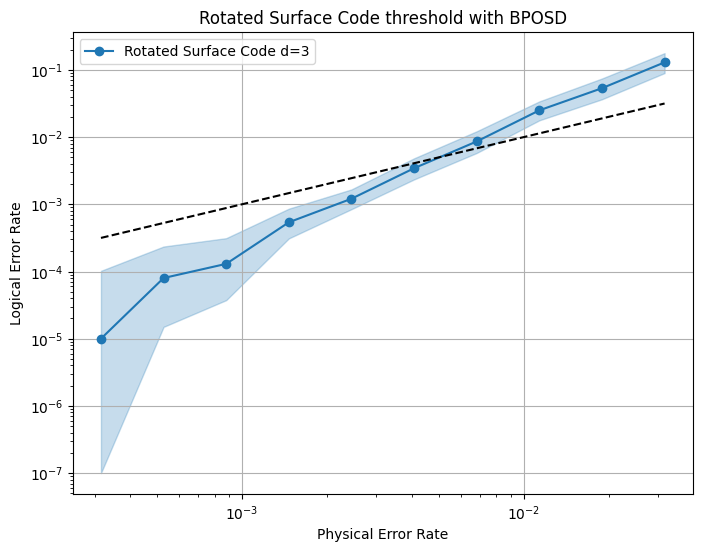

In [260]:
plot_results(samples)